# Import needed libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, BatchNormalization, concatenate, Cropping2D, Average
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device_name = tf.test.gpu_device_name()
print(device_name)

# Load Data

In [3]:
trainingset = 'train'
testset = 'test'

batch_size = 16

"""
train_datagen = ImageDataGenerator(
    zoom_range=0.3,\
    rotation_range=20,\
    width_shift_range=0.2,\
    height_shift_range=0.2,\
    horizontal_flip=True,\
    vertical_flip=False
    )
"""
train_datagen = ImageDataGenerator()

#Generate batches of image data and their corresponding labels from a directory structure
train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)
print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))


Found 6369 images belonging to 5 classes.
Found 2749 images belonging to 5 classes.
Image input (96, 96, 3)
Classes: ['0', '1', '2', '3', '4']
Loaded 6369 training samples from 5 classes.
Loaded 2749 test samples from 5 classes.


## Data distribution

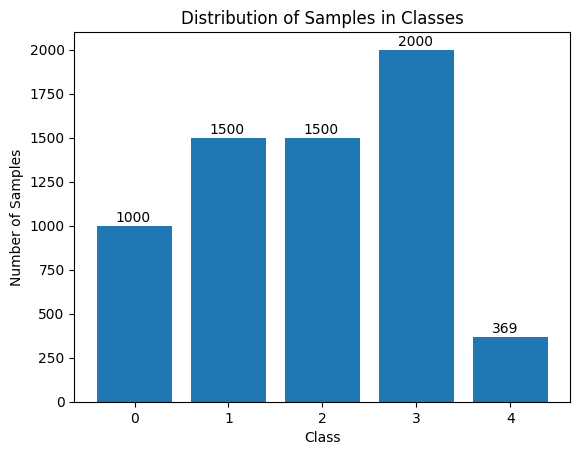

In [4]:
# Count the number of samples 
class_counts = {class_name: 0 for class_name in np.unique(train_generator.classes)}
for label in train_generator.classes:
    class_counts[label] += 1
    if sum(class_counts.values()) >= num_samples:
        break

# Plot the distribution
bars = plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples in Classes')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2, yval + 25, yval,)
plt.show()


# Model I

In [ ]:
def ModelI(input_shape, num_classes, lr=0.0001):

    model = Sequential()

    # C1 Convolutional Layer
    model.add(Conv2D(filters=32, input_shape=input_shape, kernel_size=(5,5)))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # C2 Convolutional Layer
    model.add(Conv2D(filters=64, kernel_size=(3,3)))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)

    # Dense Layer

    # model.add(Dense(128, input_shape=flatten_shape, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Dense(128, input_shape=flatten_shape))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile
    adam = optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

# create the model
model1 = ModelI(input_shape,num_classes)
model1.summary()

# define the callback
callback1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)


history = None


## Train

In [6]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_generator.classes), y = train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 1.2738, 1: 0.8492, 2: 0.8492, 3: 0.6369, 4: 3.4520325203252034}


In [ ]:
%%time
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

epochs = 100  # sets number of epochs


try:
    h = model1.fit(train_generator, epochs=epochs, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    class_weight=class_weight_dict,\
                    callbacks=[callback1],
                    validation_data=test_generator,\
                    validation_steps=val_steps
                    )
except KeyboardInterrupt:
    pass

# append current history
if history is None:
    history = h.history
else:
    history['loss'].extend(h.history['loss'])
    history['accuracy'].extend(h.history['accuracy'])
    history['val_loss'].extend(h.history['val_loss'])
    history['val_accuracy'].extend(h.history['val_accuracy'])

print("number of epochs trained: %d" %len(history['loss']))


In [ ]:
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

### Save model

In [ ]:
model1.save('models/model1_' + str(len(history['loss'])) + '_epochs_weg.h5')

## Evaluate

In [ ]:
#model = tf.keras.models.load_model('models/model1_NoAug_20_epochs.h5')

In [ ]:
val_steps=test_generator.n//test_generator.batch_size+1
print(val_steps)
loss, acc = model1.evaluate(test_generator,verbose=1,steps=val_steps)
pred = model1.predict(test_generator,verbose=1,steps=val_steps).argmax(axis=1)
#print(pred)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)
print(classification_report(test_generator.classes, pred, target_names=classnames,digits=4))


In [ ]:
ytest = test_generator.classes
cm = confusion_matrix(ytest, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classnames)
disp.plot(cmap=plt.cm.Blues)
plt.show()


conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))

# Model II

In [8]:
def model2(input_shape, num_classes, lr = 0.001):
    input_layer = Input(input_shape) 

    # 4 cov layers
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    #x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)


    # Create and compile the composite model
    adam = optimizers.Adam(learning_rate=lr)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

model2 = model2(input_shape, num_classes)

# Print the model summary
model2.summary()

# define the callback
callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

history = None

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 128)       7385

## Train

In [ ]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_generator.classes), y = train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

In [ ]:
%%time
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

epochs = 100  # sets number of epochs

h = model2.fit(train_generator, epochs=epochs, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    class_weight=class_weight_dict,\
                    callbacks=[callback2]
                    validation_data=test_generator,\
                    validation_steps=val_steps
                    )


# append current history
if history is None:
    history = h.history
else:
    history['loss'].extend(h.history['loss'])
    history['accuracy'].extend(h.history['accuracy'])
    history['val_loss'].extend(h.history['val_loss'])
    history['val_accuracy'].extend(h.history['val_accuracy'])

print("number of epochs trained: %d" %len(history['loss']))


## Evaluate

In [ ]:
val_steps=test_generator.n//test_generator.batch_size+1
print(val_steps)
loss, acc = model2.evaluate(test_generator,verbose=1,steps=val_steps)
pred = model2.predict(test_generator,verbose=1,steps=val_steps).argmax(axis=1)
#print(pred)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)
print(classification_report(test_generator.classes, pred, target_names=classnames,digits=4))

In [ ]:
ytest = test_generator.classes
cm = confusion_matrix(ytest, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classnames)
disp.plot(cmap=plt.cm.Blues)
plt.show()


conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))

### Save model

In [ ]:
model2.save('models/model2' + str(len(history['loss'])) + '_epochs_weg.h5')